# Chosing Top Real Estate Zipcodes


## Load Data

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import statsmodels.api as sm
import statistics as stats
from matplotlib.pylab import rcParams
from pandas import Grouper
from collections import Counter
plt.style.use('seaborn-bright')

import warnings
warnings.filterwarnings('ignore')

Data Preview:

In [2]:
# read in data and preview
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Preprocessing

In [3]:
# Convert all data columns to type: float
for c in df.columns[7:]:
    df[c] = df[c].astype(float)
c_entries = len(df.RegionID)
n_entries = df.size
nan_entries = df.isna().sum().sum()
print('Entries per column:                    '  , c_entries)
print('Total entries:                         '  , n_entries)
print('Total NaN entries:                     '  , nan_entries)

# Check for columns for NaNs entries greater than 10%
print('Percent of NaN entries:                '  , round(nan_entries/n_entries, 2))
print('Columns with 5% or more NaN Entries:   '  ,    (df.isna().sum()/c_entries > .05).sum())
print('Columns with 10% or more NaN Entries:  '  ,    (df.isna().sum()/c_entries > .1).sum())

Entries per column:                     14723
Total entries:                          4004656
Total NaN entries:                      157934
Percent of NaN entries:                 0.04
Columns with 5% or more NaN Entries:    112
Columns with 10% or more NaN Entries:   0


In [4]:
# convert columns with dates to datetime format

pd.to_datetime(df.columns.values[7:], format='%Y-%m')

#make a copy of the dataframe
df_c = df.copy()

In [5]:
# count how many intervals are increasing in value

increasing_zips = []
increasing_rank = []
for row in range(c_entries):
    entry_0 = 0
    increasing = 0
    decreasing = 0
    n_increasing = 0
    zipcode = df_c.RegionName[row]
    for column_name in df.columns[7:]:
        entry_1 = df_c[column_name][row]
        if entry_1 > entry_0:
            increasing += 1
        else:
            decreasing += 1 
        entry_0 = entry_1
    n_increasing = increasing - decreasing
    if n_increasing > 0:
        increasing_zips.append(zipcode)
        increasing_rank.append(n_increasing)

In [6]:
# filter the zipcodes with 70% of intervals are positive.

d = {'Zipcode':increasing_zips,'Rank': increasing_rank}
increasing_df = pd.DataFrame(d)
rank_cutoff = 0.7 * (len(df.columns)-7)
print(rank_cutoff)
zips_df = increasing_df.sort_values(by='Rank',ascending=False)[0:15]
zips = list(zips_df['Zipcode'])

# create a dataframe 
df_c = df_c[df_c.RegionName.isin(zips)]

185.5


In [7]:

# Compute % change for the last few years to choose 
# zipcodes with greatest potential for growth in the 
# coming years.

df_c['delta1'] =  (df_c['2018-04'] - df_c['2017-12'])/(df_c['2017-12'])
df_c['delta2'] =  (df_c['2018-04'] - df_c['2017-04'])/(df_c['2017-04'])
df_c['delta3'] =  (df_c['2017-04'] - df_c['2016-04'])/(df_c['2016-04'])
df_c['delta4'] =  (df_c['2016-04'] - df_c['2015-04'])/(df_c['2015-04'])

# Created a filter to extract zipcodes 
d1 = df_c[(df_c.delta1 >= .02)  & (df_c.delta1 <= .10) & 
          (df_c.delta2 >= .02)  & 
          (df_c.delta3 >= 0)    &
          (df_c.delta4 >= 0)].sort_values(by='delta1',ascending=False)

# create a list with the zipcodes that satisfy above criteria
zips = list(d1.RegionName)
zips

[80904, 80212, 11221, 80211, 80210, 11216, 37216, 80521, 20009]

In [8]:
# filter out zipcodes with standard deviations greater than a threshhold.
zips_filt = []
for z in zips:
    df_z = df_c[df_c.RegionName==z]
    ts = df_z.values[0][7:]
    std = np.std(ts)
    if (std  < 110000):
        zips_filt.append(z)

len(zips_filt)


5

In [9]:
# define a function to convert from long format to short format
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','SizeRank','RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted.set_index('time',inplace=True)
    melted.dropna(inplace=True)
    return melted
    #return melted.groupby('time').aggregate({'value':'mean'})

In [10]:
# create a short format dataframe to hold data for top zipcodes
zip_df = pd.DataFrame()
for z in zips_filt:
    d = melt_data(df[df.RegionName==z])
    zip_df = pd.concat([d,zip_df])
zip_df.head()

,RegionID,SizeRank,RegionName,City,State,Metro,CountyName,value
time,,,,,,,,
1996-04-01,93445,2492,80521,Fort Collins,CO,Fort Collins,Larimer,113900.0
1996-05-01,93445,2492,80521,Fort Collins,CO,Fort Collins,Larimer,114200.0
1996-06-01,93445,2492,80521,Fort Collins,CO,Fort Collins,Larimer,114400.0
1996-07-01,93445,2492,80521,Fort Collins,CO,Fort Collins,Larimer,114700.0
1996-08-01,93445,2492,80521,Fort Collins,CO,Fort Collins,Larimer,115000.0


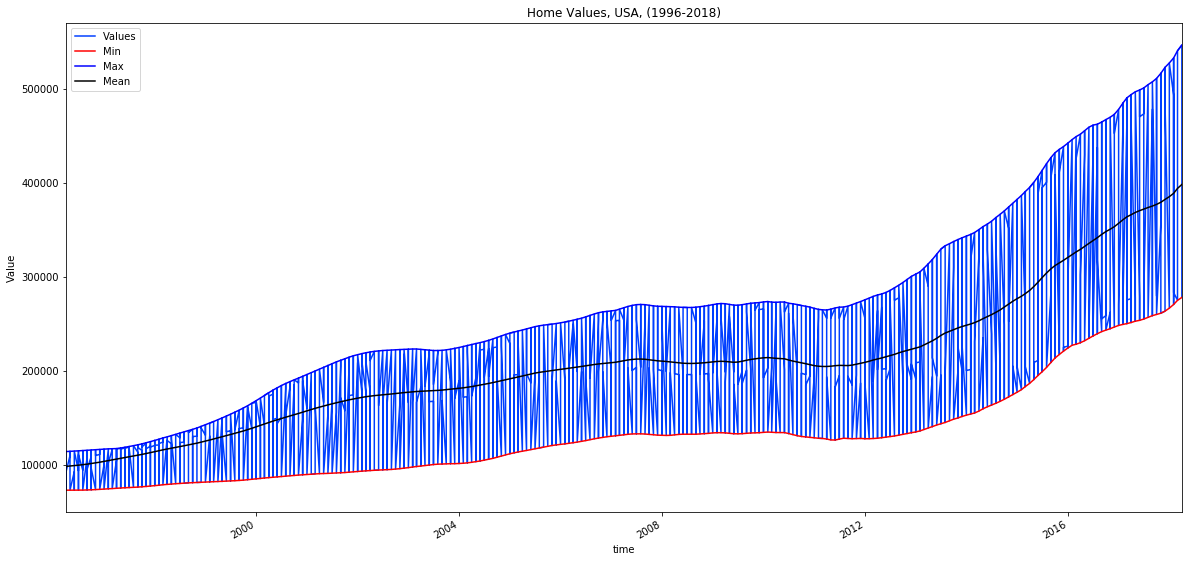

In [11]:
# plot the entirety of data for all zipcodes and observe overall trend
# make sure this satisfies criteria: (Low STD and overall increasing trend)

zip_df.value.plot(figsize=(20,10),label='Values')
min_ = zip_df.groupby('time').aggregate({'value':'min'})
max_ = zip_df.groupby('time').aggregate({'value':'max'})
mean_ = zip_df.groupby('time').aggregate({'value':'mean'})
plt.plot(min_, color= 'red',label='Min')
plt.plot(max_, color='blue',label = 'Max')
plt.plot(mean_, color= 'black',label= 'Mean')
plt.legend()
plt.title('Home Values, USA, (1996-2018)')
plt.ylabel('Value')
plt.show()

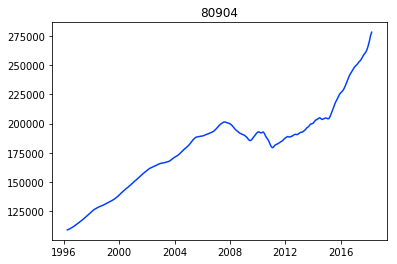

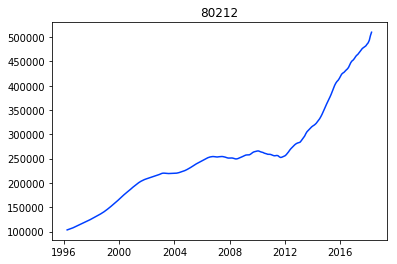

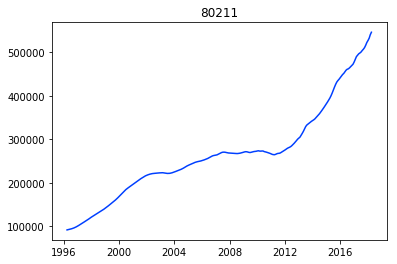

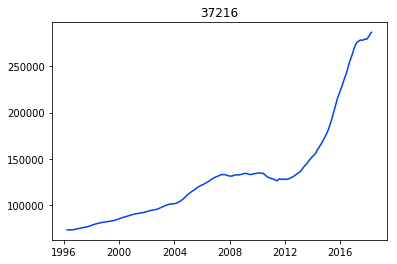

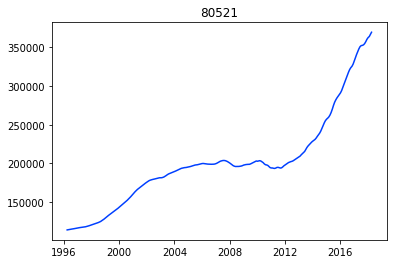

In [12]:
# create plots for QC each zipcode 

for z in zips_filt:
    df_z = zip_df[zip_df.RegionName == z]
    ts = df_z.value
    plt.plot(ts)
    plt.title(z)
    plt.show()


All looks good

# Step 3: EDA and Visualization

Understand amount of missing entries:

In [13]:
# Create lists for each geographical division.
states = zip_df.State.sort_values().unique()
metros = zip_df.Metro.sort_values().unique()
cities = zip_df.City.sort_values().unique()
zipcodes = zip_df.RegionName.sort_values().unique()

# print number of geographical divisions
print('In this dataset, we have information for: ')
print('States: ', len(states), ', Metros: ',len(metros), ', Cities: ' , len(cities), ', Zipcodes: ', len(zipcodes))

In this dataset, we have information for: 
States:  2 , Metros:  4 , Cities:  4 , Zipcodes:  5


In [14]:
print(states, metros, cities, zipcodes)

['CO' 'TN'] ['Colorado Springs' 'Denver' 'Fort Collins' 'Nashville'] ['Colorado Springs' 'Denver' 'Fort Collins' 'Nashville'] [37216 80211 80212 80521 80904]


# Step 5: ARIMA Modeling

In [15]:
# Decide AR, MA and order of these models

In [16]:
# Fit model to get the correct paramenters
# and use for predicition

In [17]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [18]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
for z in zipcodes: 
    df_z = zip_df[zip_df.RegionName == z]
    values = df_z.value

    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(values,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs,output.aic))
            except:
                continue
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    print(z)
    print(ans_df.loc[ans_df['aic'].idxmin()])


ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7019.565878801543
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6548.18181074648
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5611.993384917069
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5356.715372508541
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5440.240683228392
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5395.592435256117
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5058.253931970414
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =6703.765062911555
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =6802.713799652223
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =6450.225404558764
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5424.2223577642435
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =7064.3896657599635
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =6480.777441547267
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6431.435723267281
ARIMA (0, 0, 1) x (

ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3792.854738164501
ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3792.325749586101
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =3996.575198299384
ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =3813.491010192149
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3974.6195249160046
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3704.3533552948893
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =3830.957598851771
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =3815.3960884714347
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3776.094075716998
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3742.3540456195165
80211
pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           3704.35
Name: 59, dtype: object
ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7361.403846176594
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =154365.7387734062
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5803.451

ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =3975.502358477382
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =4087.195289147363
ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =3751.080213101007
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =4010.7192225176045
ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =3977.721280876161
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =3756.139930703057
ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =4000.4119603236422
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =3875.3256952803727
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =3702.6378110352225
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3873.2342493525002
ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3663.0239126814713
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =3704.798699493992
ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =3706.79698892934
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3643.1029562673048
ARIMA (1, 1, 0

In [56]:
def arima(zip_df, z, p, d, q, s, p2):
    df_z = zip_df[zip_df.RegionName == z]
    values = df_z.value

    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(values,
                                order=(p, d, q),
                                seasonal_order=(p2, d, q, s),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    print(z)
    output = ARIMA_MODEL.fit()

    print(output.summary().tables[1])

    output.plot_diagnostics(figsize=(15, 18))
    plt.show()
    
    # ================= ONE STEP AHEAD FORECAST ==================

    pred = output.get_prediction(start=pd.to_datetime('2014-01'), dynamic=False)
    pred_conf = pred.conf_int()

    rcParams['figure.figsize'] = 10, 6

    #Plot observed values
    ax = df_z.value['1996-04':].plot(label='observed')

    #Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.5)

    #Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Home Values')
    plt.legend()

    plt.show()
    
   
    # Get the Real and predicted values
    value_forecasted = pred.predicted_mean
    value_truth = df_z.value['2014-01':]

    # Compute the mean square error
    mse = ((value_forecasted - value_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

    # ========================  DYNAMIC PREDICTION   ====================
    
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2014-01'), dynamic=True, full_results=True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    
    ax = df_z.value['1996-04':].plot(label='observed', figsize=(10, 15))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2014-01'), value_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Home Values')

    plt.legend()
    plt.show()
    
    # Extract the predicted and true values of our time series
    value_forecasted = pred_dynamic.predicted_mean
    value_truth = df_z.value['2014-01':]

    # Compute the mean square error
    mse = ((value_forecasted - value_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    
    #==========================         ===========================

    # Get forecast 500 steps ahead in future
    prediction = output.get_forecast(steps=500)

    # Get confidence intervals of forecasts
    pred_conf = prediction.conf_int()
    ax = df_z.value.plot(label='observed', figsize=(20, 15))
    prediction.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Home Values')

    plt.legend()
    plt.show()

80211
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8070      0.029     28.203      0.000       0.751       0.863
ma.L1          0.6385      0.031     20.746      0.000       0.578       0.699
ma.S.L12      -0.5930      0.035    -16.937      0.000      -0.662      -0.524
sigma2      2.811e+05   1.73e+04     16.234      0.000    2.47e+05    3.15e+05


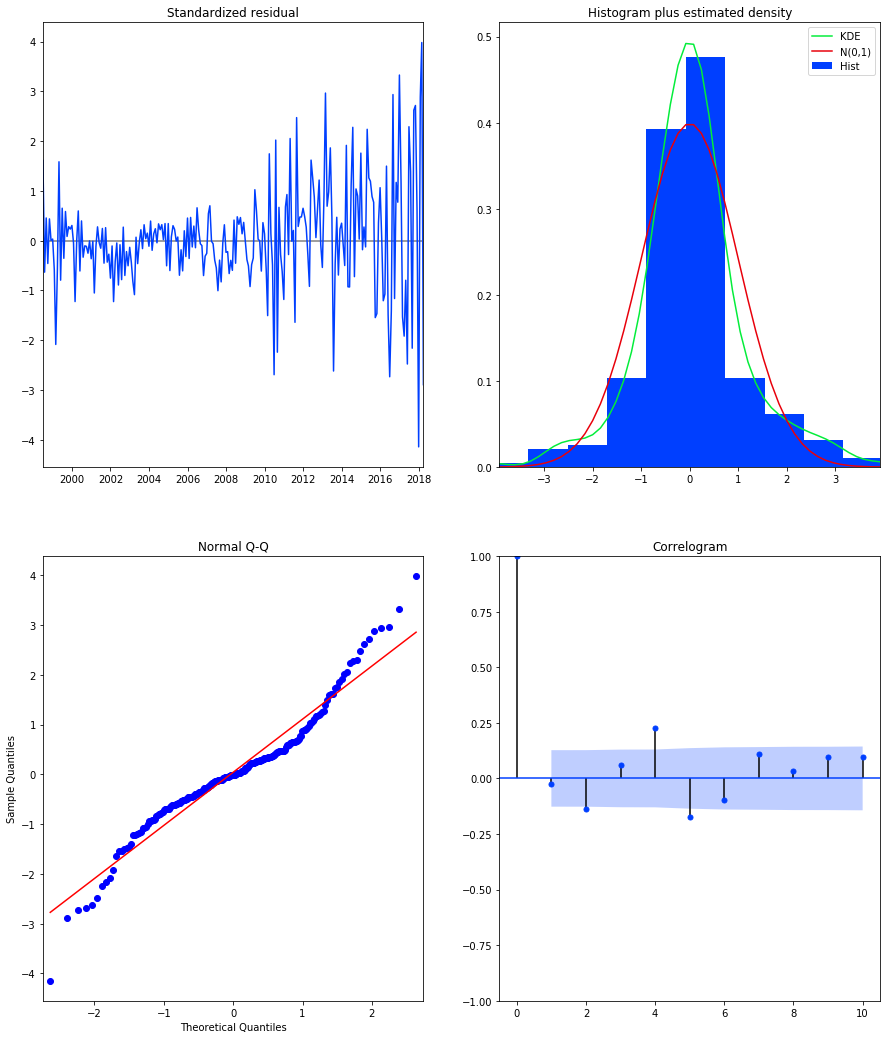

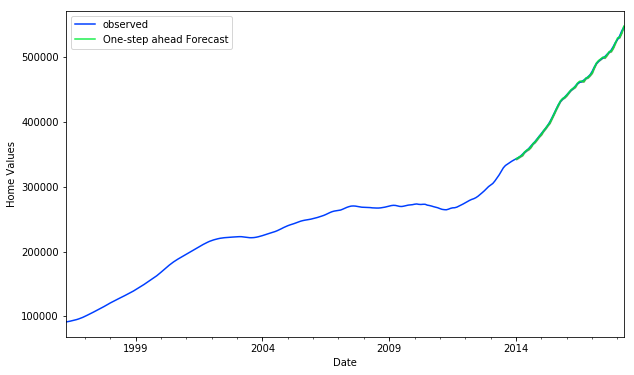

The Mean Squared Error of our forecasts is 880790.6


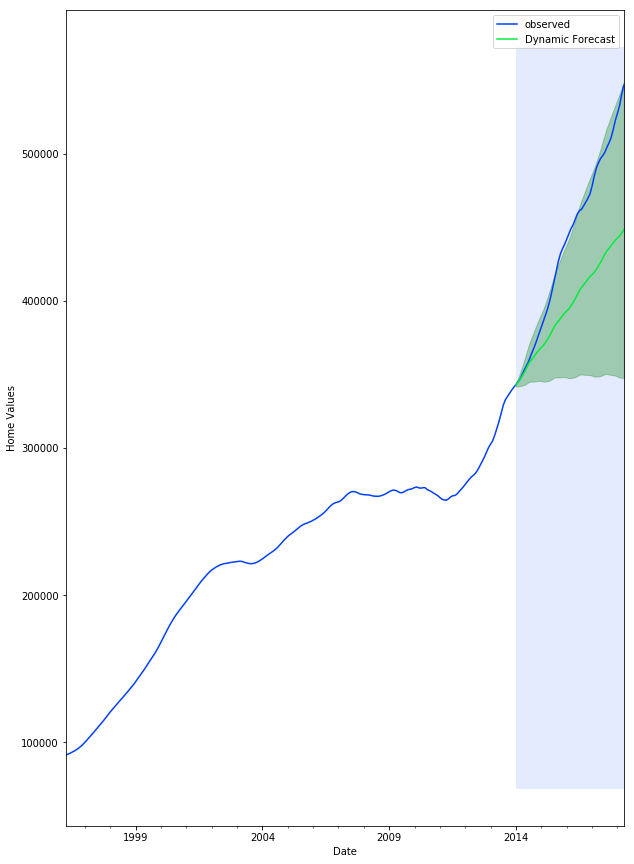

The Mean Squared Error of our forecasts is 2712351613.88


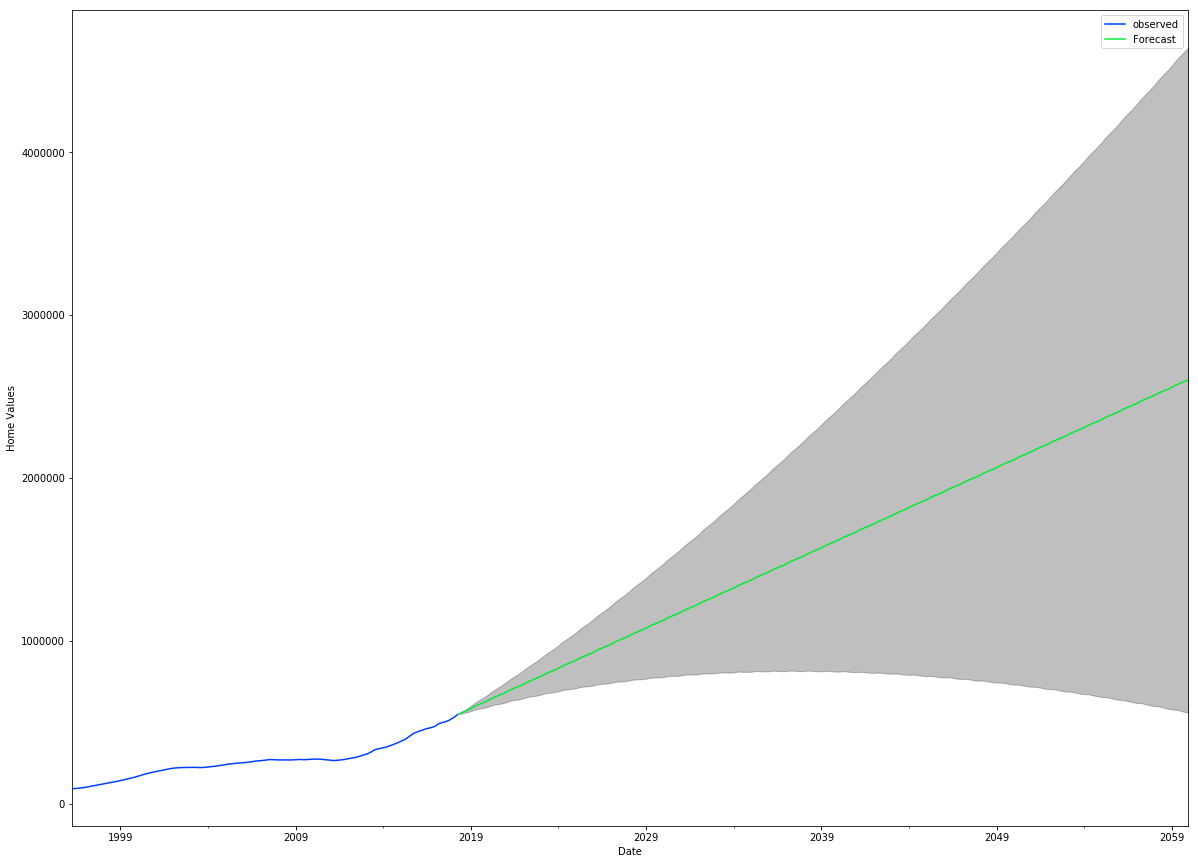

In [57]:
arima(zip_df, 80211, 1, 1, 1, 12, 0)

80212
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8436      0.024     35.268      0.000       0.797       0.890
ma.L1          0.6172      0.023     27.302      0.000       0.573       0.661
ar.S.L12       0.0823      0.044      1.863      0.062      -0.004       0.169
ma.S.L12      -0.7537      0.060    -12.542      0.000      -0.872      -0.636
sigma2      3.004e+05   1.39e+04     21.668      0.000    2.73e+05    3.28e+05


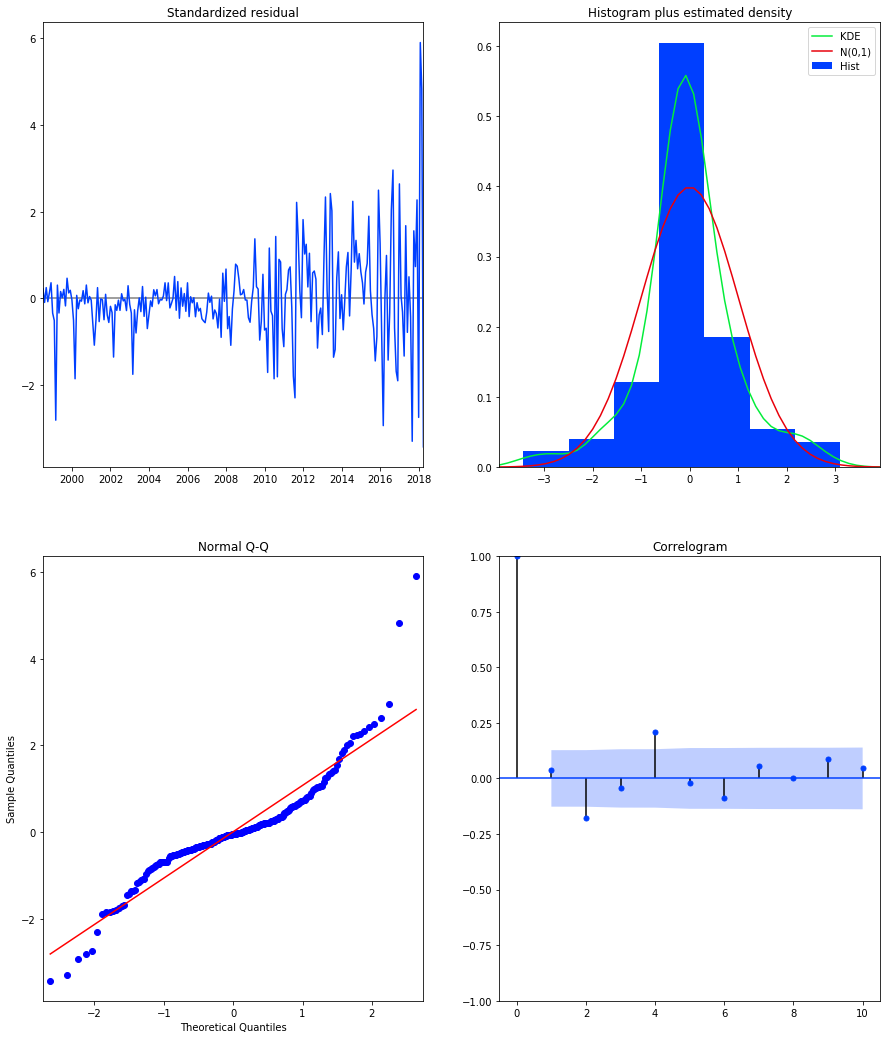

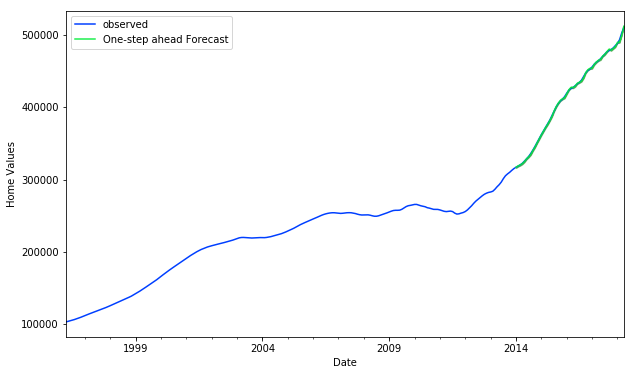

The Mean Squared Error of our forecasts is 980699.06


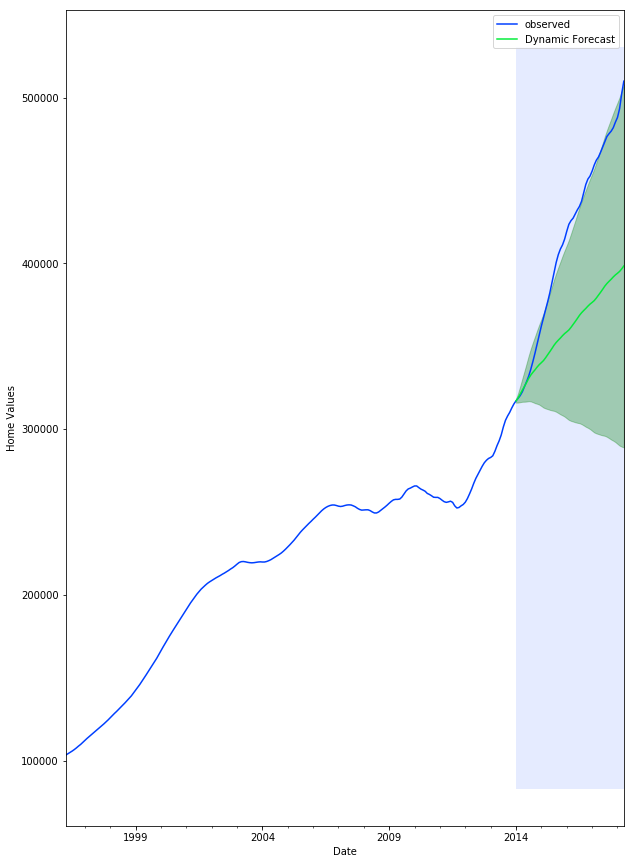

The Mean Squared Error of our forecasts is 4038539225.87


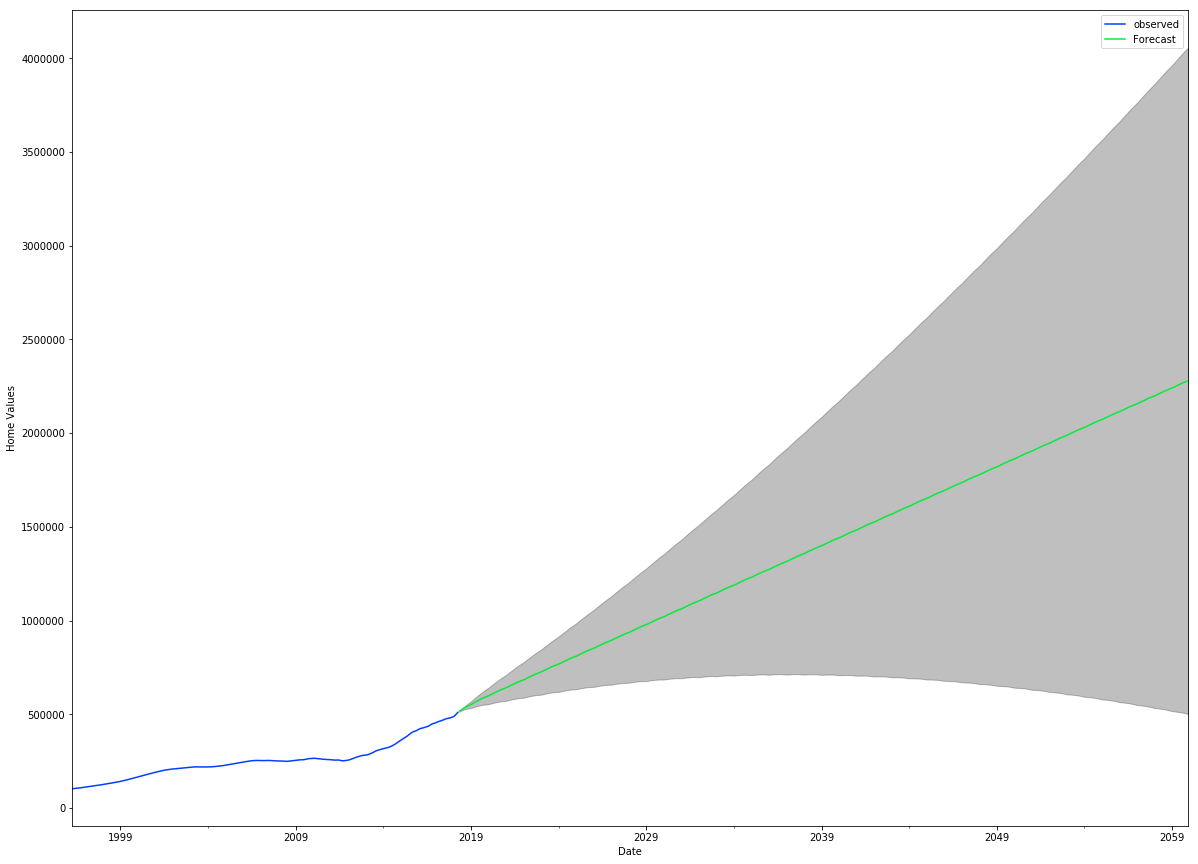

In [58]:
arima(zip_df, 80212, 1, 1, 1, 12, 1)

80521
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8234      0.029     28.071      0.000       0.766       0.881
ma.L1          0.6071      0.037     16.213      0.000       0.534       0.681
ma.S.L12      -0.6366      0.045    -13.991      0.000      -0.726      -0.547
sigma2      1.292e+05   8395.748     15.392      0.000    1.13e+05    1.46e+05


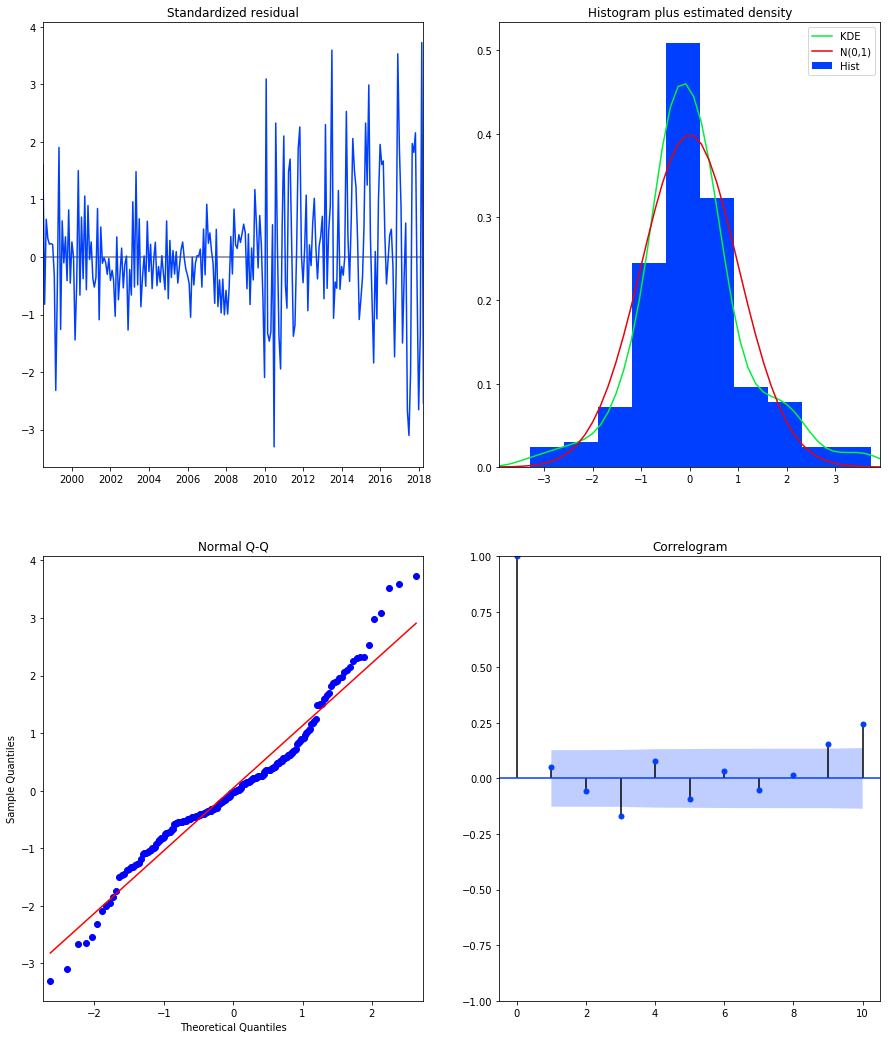

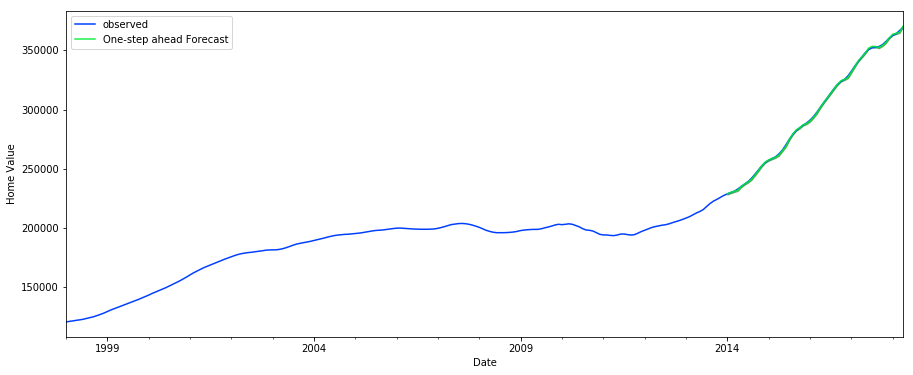

In [35]:
arima(zip_df, 80521, 1, 1, 1, 12, 0)

80904
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8298      0.025     33.577      0.000       0.781       0.878
ma.L1          0.6551      0.035     18.605      0.000       0.586       0.724
ma.S.L12      -0.8464      0.035    -24.347      0.000      -0.915      -0.778
sigma2      1.076e+05   6592.796     16.321      0.000    9.47e+04    1.21e+05


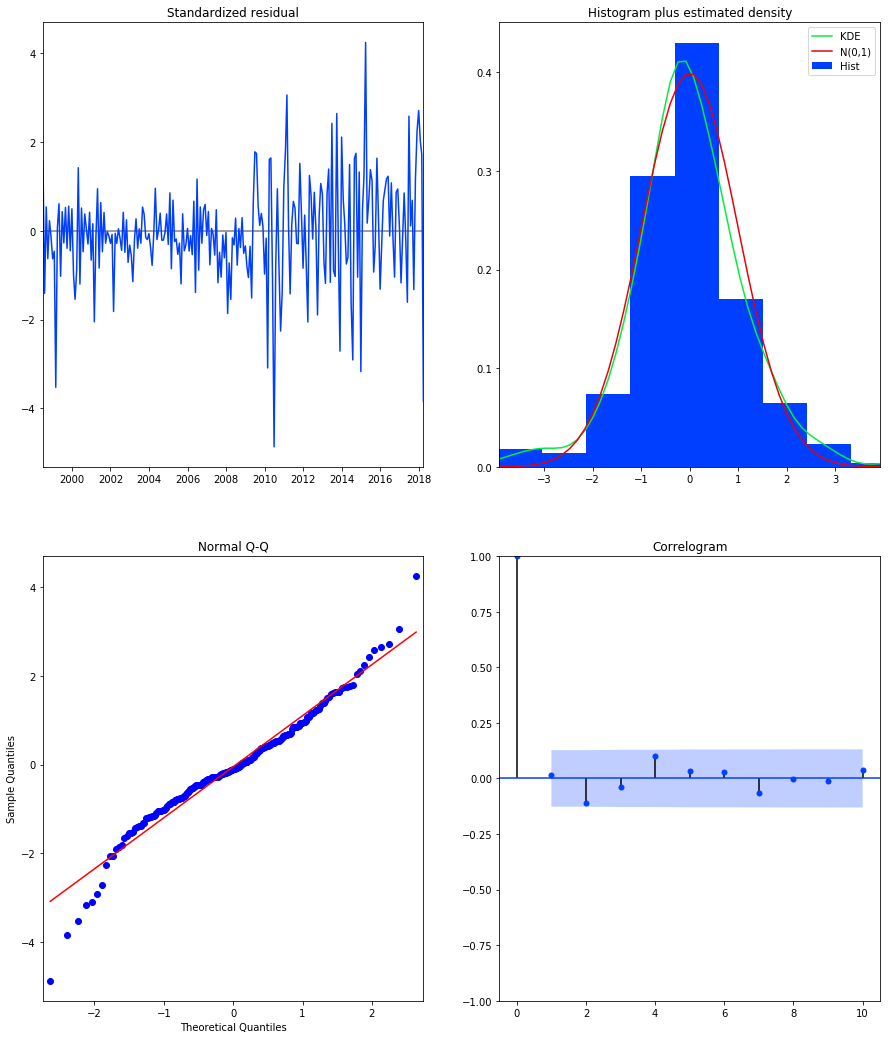

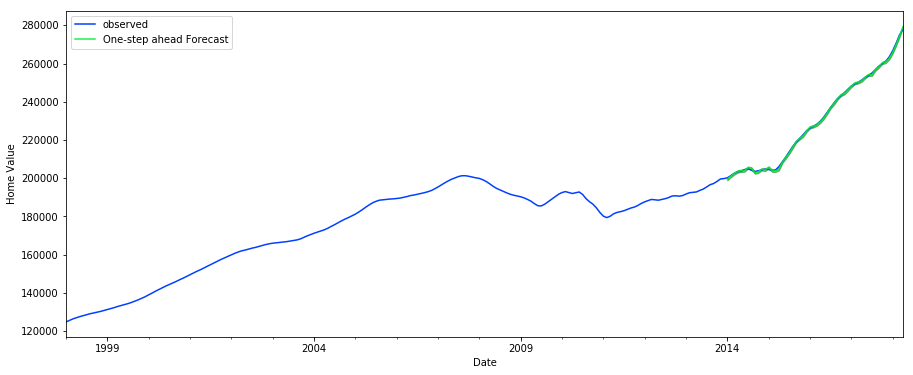

In [36]:
arima(zip_df, 80904, 1, 1, 1, 12, 0)

37216
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9237      0.016     57.598      0.000       0.892       0.955
ma.L1          0.5101      0.042     12.235      0.000       0.428       0.592
ar.S.L12       0.0320      0.022      1.435      0.151      -0.012       0.076
ma.S.L12      -0.9966      1.073     -0.929      0.353      -3.100       1.107
sigma2      9.044e+04   9.57e+04      0.945      0.345   -9.72e+04    2.78e+05


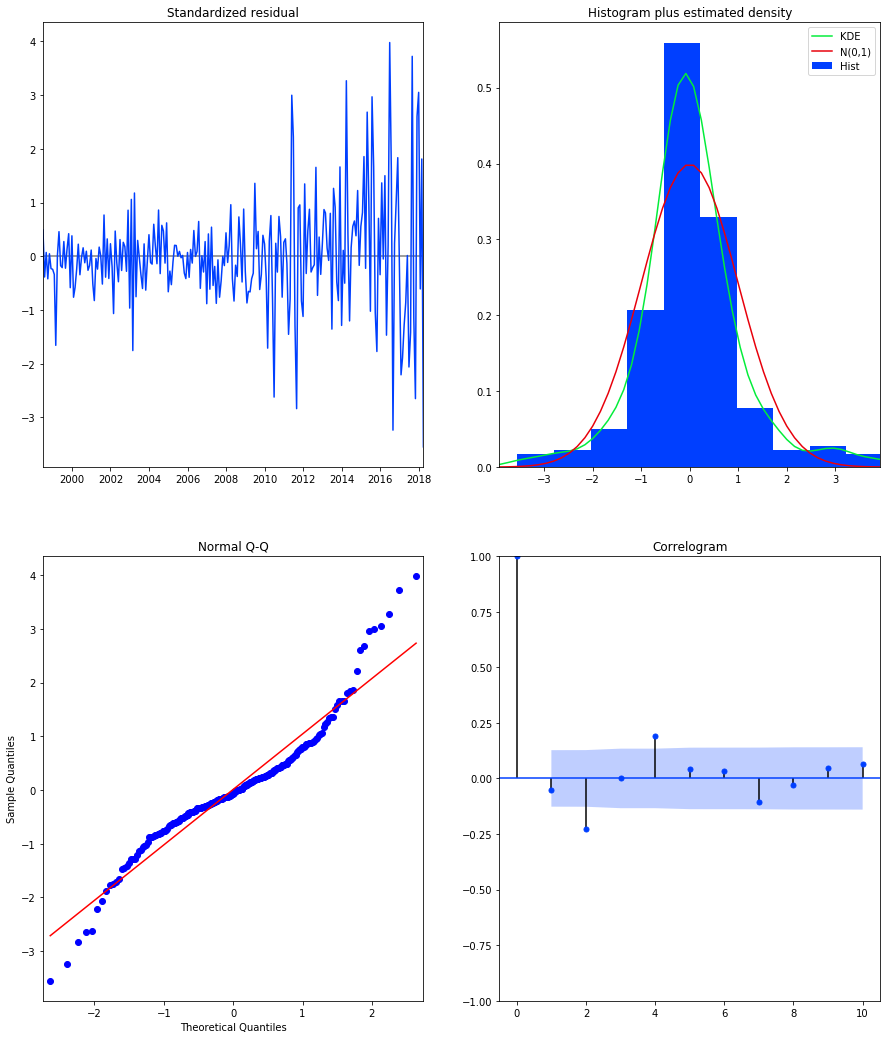

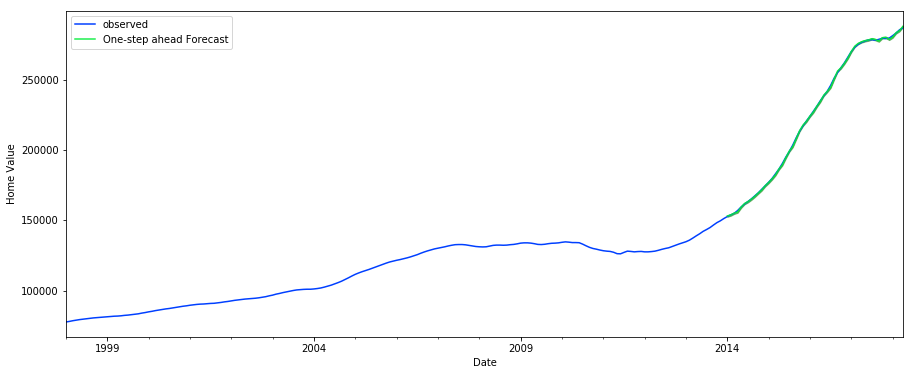

In [37]:
arima(zip_df, 37216, 1, 1, 1, 12, 1)

# Step 6: Interpreting Results